# Initalizing the SAM predictor
This code section initalizes the original SAM model and functions that come from the Meta notebooks.

In [1]:
import os
import sys
import numpy as np
path = '/mnt/vstor/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman-2/topics/aml-fractography/sam'
sys.path.append(path)
from segment_anything import sam_model_registry, SamPredictor
import urllib.request
import cv2
import pandas as pd
import math
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
import organize_data

sam_checkpoint = path +"/sam_vit_h_4b8939.pth"
# url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
# sam_checkpoint = urllib.request.urlretrieve(url)

model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

#Define metric functions
def perimeter_coverage(mask):
    # Get the dimensions of the mask
    height, width = mask.shape
    mask = mask.astype(np.uint8)
    if(np.max(mask)!=255):
        mask = mask*255
    # Extract the perimeter: first and last rows, and first and last columns
    perimeter_pixels = np.concatenate([
        mask[0, :],  # Top row
        mask[-1, :],  # Bottom row
        mask[0:-1, 0],  # Left column
        mask[0:-1, -1]  # Right column
    ])
    if(mask.dtype==np.uint8):
        max_size=2**8 -1
    elif(mask.dtype==np.uint16):
        max_size=2**16 -1
    elif(mask.dtype==np.uint32):
        max_size=2**32 -1
    elif(mask.dtype==np.uint64):
        max_size=2**64 -1
    elif(mask.dtype==np.float16 or mask.dtype==np.float32 or mask.dtype==np.float64):
        max_size=2**32 -1
    else:
        raise TypeError('Mask must be an unsigned interger or float. Was type:'+str(mask.dtype))

    # Total perimeter pixels
    total_perimeter_pixels = len(perimeter_pixels)*max_size

    # Count how many of those pixels are part of the mask (assuming mask is binary 1/0)
    covered_perimeter_pixels = np.sum(perimeter_pixels)

    # Calculate the percentage of the perimeter covered by the mask
    coverage_ratio = covered_perimeter_pixels / total_perimeter_pixels if total_perimeter_pixels != 0 else 0

    return coverage_ratio

#From Claude 3.5 Connet Oct.24, 2024
def unfilled_ratio(img):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    # Apply threshold to get binary image
    _, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0
    
    # Find the largest contour (assuming it's the main object)
    main_contour = max(contours, key=cv2.contourArea)
    
    # Calculate total area within the outer contour
    total_area = cv2.contourArea(main_contour)

    # Calculate area of holes
    holes_area = 0
    print(len(contours))
    if hierarchy is not None:
        for i, h in enumerate(hierarchy[0]):
            # If this contour has a parent (meaning it's a hole)
            if h[3] >= 0:  # h[3] is the index of the parent contour
                holes_area += cv2.contourArea(contours[i])
    
    # Calculate ratio
    if total_area == 0:
        return 0
    print('total area: '+str(total_area))
    print('holes area: '+str(holes_area))
    unfilled_ratio = holes_area / total_area

    # # Create visualization
    # # visualization = img.copy()
    # Draw main contour in green
    # cv2.drawContours(visualization, [main_contour], -1, (0, 255, 0), 2)
    # # Draw holes in red
    # for i, h in enumerate(hierarchy[0]):
    #     if h[3] >= 0:  # If it's a hole
    #         cv2.drawContours(visualization, [contours[i]], -1, (0, 0, 255), 2)
    
    # Add text with measurements
    # cv2.putText(visualization, f'Total Area: {total_area:.0f}', (10, 30),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.putText(visualization, f'Holes Area: {holes_area:.0f}', (10, 60),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.putText(visualization, f'Ratio: {fill_ratio:.3f}', (10, 90),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    # cv2.imshow('fill visualization',visualization)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return unfilled_ratio

organize_data


# SAM Segment Initiating Defect
This section was used to attempt to segment the initiating defect from the entire surface. This was ultimentaly deemed too complex and was done manuelly using xanylabeling.

In [2]:
'''Interative SAM'''
# This section was used to look how SAM interacted with individal images
# Needs to be rewritten to work with the now tidied data

#Sorting Data
combined_df = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv')
df = combined_df[combined_df['image_basename'].apply(lambda x: type(x)==str)] #Drops nas, which are loaded as floats
df = df.groupby('sample_id')
x_sup = []
y_sup = []
for group_string, sample in df:
    if 'fatigue' in sample['image_class'].value_counts().index and 'full_surface_unmarked' in sample['image_class'].value_counts().index:
        y_sup.append(sample[(sample['image_class']=='fatigue') & (sample['image_path'].apply(lambda x: '.png' in x))]['image_path'].iloc[0])
        x_sup.append(sample[(sample['image_class']=='full_surface_unmarked')]['image_path'].iloc[0])
x_temp = pd.Series(x_sup,name='input')
y_temp = pd.Series(y_sup,name='output')
temp_df = pd.concat([x_temp,y_temp],axis=1)
temp_df.to_csv(args.path + '/dataset.csv')

idx += 1
d_pos = .3
grid_spacing = 32
RANDOM_POSITIONS=20
task='path_initiation'
input_size = 1024


all_points = []
input_label = []
image = read_img(combined_df,task)
image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
if(input_size==1024):
    image = image[0:960,:]
    input_size = 960
image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
all_points = []
input_label = []

#Remove reflective edges
condition_img = image_blurred>253
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
if len(non_zero_indices[0]) > 0:
    for i in range(RANDOM_POSITIONS):
        temp_idx = int(random.random()*len(non_zero_indices[0]))
        all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
        input_label.append(0)
    #Removed whited out regions
    condition_img = i
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)

# plt.axis('on')
fig_segment_main_area.show()
image_blurred==0
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
if len(non_zero_indices[0]) > 0:
    for i in range(RANDOM_POSITIONS):
        temp_idx = int(random.random()*len(non_zero_indices[0]))
        all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
        input_label.append(0)

x_mid = image.shape[-2]/2
y_mid = image.shape[-3]/2
d_disp = math.sqrt((x_mid**2)+(y_mid**2))*d_pos
x_disp = math.sin(math.radians(45))*d_disp
y_disp = math.cos(math.radians(45))*d_disp

#Add positive prompt to center
for x_pos in [x_mid - x_disp,x_mid,x_mid+x_disp]:
    for y_pos in [y_mid - y_disp,y_mid,y_mid+y_disp]:
        all_points.append([x_pos,y_pos])
        input_label.append(1)
# Add negative prompt on the bottom
# for x_pos in [*range(0,input_size+32,32)]:
#         all_points.append([x_pos,input_size*.97])
#         input_label.append(0)


predictor.set_image(image_blurred)
masks, scores, logits = predictor.predict(
    point_coords=np.array(all_points),
    point_labels=np.array(input_label),
    multimask_out
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)

# plt.axis('on')
fig_segment_main_area.show()put=True,
    
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

def find_area(mask):
    total = 1
    for i in mask.shape:
        total = total*i
    return np.sum(mask) / total
masks_area = []
for i in masks:
    masks_area.append(find_area(i))
max_idx = masks_area.index(max(masks_area))

processed_mask = (masks[max_idx]).astype(np.uint8) * 255

# Step 1: Label connected components
num_labels, labels_im = cv2.connectedComponents(processed_mask)

# Step 2: Count pixels for each label
sizes = np.bincount(labels_im.ravel())

# Step 3: Find the largest component (ignore the background)
largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

# Step 4: Create a new mask for the largest component
largest_defect_mask = np.zeros_like(processed_mask)
largest_defect_mask[labels_im == largest_component_label] = 255
processed_mask = largest_defect_mask
# Creating kernel 
dilate_kernel = np.ones((6, 6), np.uint8)
erosion_kernal = np.ones((6, 6), np.uint8)
# Using cv2.erode() method  
processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

# fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
def fill_mask_holes(mask):
    """
    Fill holes in a binary mask using floodFill.
    
    Parameters:
    mask (numpy.ndarray): Binary input mask (0 and 255 values)
    
    Returns:
    numpy.ndarray: Mask with holes filled
    """
    # Ensure mask is binary and of type uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Threshold to ensure binary image
    _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    
    # Create a copy of the mask for flood filling
    # Note: floodFill needs a mask that's 2 pixels bigger in each direction
    h, w = binary_mask.shape
    filled_mask = binary_mask.copy()
    filling_mask = np.zeros((h + 2, w + 2), np.uint8)
    
    # Flood fill from point (0,0)
    cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
    
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)

# plt.axis('on')
fig_segment_main_area.show()
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)
# max_mask = processed_mask
all_points_processed = []
input_label_processed = []
for x_pos in [*range(0,input_size-1,grid_spacing)]:
    for y_pos in [*range(0,input_size-1,grid_spacing)]:
        if(processed_mask[x_pos,y_pos]!=0):
            all_points_processed.append([y_pos,x_pos])
            input_label_processed.append(1)            

predictor.set_image(image)
masks_processed, scores_processed, logits_processed = predictor.predict(
    point_coords=np.array(all_points_processed),
    point_labels=np.array(input_label_processed),
    multimask_output=True,
)
sorted_ind = np.argsort(scores_processed)[::-1]
masks_processed = masks_processed[sorted_ind]
scores_processed = scores_processed[sorted_ind]
logits_processed = logits_processed[sorted_ind]

#Visualization
show_masks(image_blurred, masks, scores, point_coords=np.array(all_points), input_labels=np.array(input_label), borders=True)
#show_masks(image, masks_processed, scores_processed, input_labels=np.array(input_label_processed), borders=True)
fig_segment_main_area,ax = plt.subplots(ncols=3,nrows=3,figsize=(15,15))

title = 'Surface Prompts'
ax[0,0].set_title(title)
ax[0,0].imshow(image_blurred)
show_points(np.array(all_points), np.array(input_label), ax[0,0])

title = 'Surface SAM Output'+ '\nPerimeter: '+str(perimeter_coverage(masks[max_idx]))[0:7] +'\nRatio: '+str(unfilled_ratio(masks[max_idx]))[0:7]
ax[0,1].set_title(title)
ax[0,1].imshow(masks[max_idx],cmap='gray')

title = 'Surface SAM Processed'+ '\nPerimeter: '+str(perimeter_coverage(max_mask))[0:7]+'\nRatio: '+str(unfilled_ratio(max_mask))[0:7]
ax[0,2].set_title(title)
ax[0,2].imshow(max_mask,cmap='gray')

title = 'Raw image'
ax[1,0].set_title(title)
ax[1,0].imshow(image,cmap='gray')

title = 'Defect Processing'
ax[1,1].set_title(title)
ax[1,1].imshow(image,cmap='gray')
show_points(np.array(all_points_processed), np.array(input_label_processed), ax[1,1])

ax[1,2].set_title('Empty')

title = 'Defect Mask 1'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[0]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[0]))[0:7]
ax[2,0].set_title(title)
ax[2,0].imshow(masks_processed[0],cmap='gray')

title = 'Defect Mask 2'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[1]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[1]))[0:7]
ax[2,1].set_title(title)
ax[2,1].imshow(masks_processed[1],cmap='gray')

title = 'Defect Mask 3'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[2]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[2]))[0:7]
ax[2,2].set_title(title)
ax[2,2].imshow(masks_processed[2],cmap='gray')

# plt.axis('on')
fig_segment_main_area.show()

SyntaxError: invalid character '…' (U+2026) (2475387070.py, line 162)

In [3]:
idx += 1
d_pos = .3
grid_spacing = 32
RANDOM_POSITIONS=20
task='path_initiation'
input_size = 1024
save_path = '/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/SAM_initiating_defect'

all_points = []
input_label = []
image = read_img(combined_df,task)
image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
if(input_size==1024):
    image = image[0:960,:]
    input_size = 960
image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
all_points = []
input_label = []

#Remove reflective edges
condition_img = image_blurred>253
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
if len(non_zero_indices[0]) > 0:
    for i in range(RANDOM_POSITIONS):
        temp_idx = int(random.random()*len(non_zero_indices[0]))
        all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
        input_label.append(0)

fig_segment_main_area.show()mage_blurred==0
non_zero_indices = np.nonzero(np.where(condition_img,1,0))
if len(non_zero_indices[0]) > 0:
    for i in range(RANDOM_POSITIONS):
        temp_idx = int(random.random()*len(non_zero_indices[0]))
        all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
        input_label.append(0)

x_mid = image.shape[-2]/2
y_mid = image.shape[-3]/2
d_disp = math.sqrt((x_mid**2)+(y_mid**2))*d_pos
x_disp = math.sin(math.radians(45))*d_disp
y_disp = math.cos(math.radians(45))*d_disp

#Add positive prompt to center
for x_pos in [x_mid - x_disp,x_mid,x_mid+x_disp]:
    for y_pos in [y_mid - y_disp,y_mid,y_mid+y_disp]:
        all_points.append([x_pos,y_pos])
        input_label.append(1)
# Add negative prompt on the bottom
# for x_pos in [*range(0,input_size+32,32)]:
#         all_points.append([x_pos,input_size*.97])
#         input_label.append(0)


predictor.set_image(image_blurred)
masks, scores, logits = predictor.predict(
    point_coords=np.array(all_points),
    point_labels=np.array(input_label),
    multimask_out=True)
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)
…
# plt.axis('on')
fig_segment_main_area.show()
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

def find_area(mask):
    total = 1
    for i in mask.shape:
        total = total*i
    return np.sum(mask) / total
masks_area = []
for i in masks:
    masks_area.append(find_area(i))
max_idx = masks_area.index(max(masks_area))

processed_mask = (masks[max_idx]).astype(np.uint8) * 255

# Step 1: Label connected components
num_labels, labels_im = cv2.connectedComponents(processed_mask)

# Step 2: Count pixels for each label
sizes = np.bincount(labels_im.ravel())

# Step 3: Find the largest component (ignore the background)
largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

# Step 4: Create a new mask for the largest component
largest_defect_mask = np.zeros_like(processed_mask)
largest_defect_mask[labels_im == largest_component_label] = 255
processed_mask = largest_defect_mask
# Creating kernel 
dilate_kernel = np.ones((6, 6), np.uint8)
erosion_kernal = np.ones((6, 6), np.uint8)
# Using cv2.erode() method  
processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
# processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

# fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
def fill_mask_holes(mask):
    """
    Fill holes in a binary mask using floodFill.
    
    Parameters:
    mask (numpy.ndarray): Binary input mask (0 and 255 values)
    
    Returns:
    numpy.ndarray: Mask with holes filled
    """
    # Ensure mask is binary and of type uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Threshold to ensure binary image
    _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    
    # Create a copy of the mask for flood filling
    # Note: floodFill needs a mask that's 2 pixels bigger in each direction
    h, w = binary_mask.shape
    filled_mask = binary_mask.copy()
    filling_mask = np.zeros((h + 2, w + 2), np.uint8)
    
    # Flood fill from point (0,0)
    cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
    
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)
…
# plt.axis('on')
fig_segment_main_area.show()
    # Invert the flood-filled image
    filled_mask_inv = cv2.bitwise_not(filled_mask)
    
    # Combine the original mask with the filled holes
    out_mask = binary_mask | filled_mask_inv
    
    return out_mask
max_mask = fill_mask_holes(processed_mask)
# max_mask = processed_mask
all_points_processed = []
input_label_processed = []
for x_pos in [*range(0,input_size-1,grid_spacing)]:
    for y_pos in [*range(0,input_size-1,grid_spacing)]:
        if(processed_mask[x_pos,y_pos]!=0):
            all_points_processed.append([y_pos,x_pos])
            input_label_processed.append(1)            

predictor.set_image(image)
masks_processed, scores_processed, logits_processed = predictor.predict(
    point_coords=np.array(all_points_processed),
    point_labels=np.array(input_label_processed),
    multimask_output=True,
)
sorted_ind = np.argsort(scores_processed)[::-1]
masks_processed = masks_processed[sorted_ind]
scores_processed = scores_processed[sorted_ind]
logits_processed = logits_processed[sorted_ind]

#Visualization
show_masks(image_blurred, masks, scores, point_coords=np.array(all_points), input_labels=np.array(input_label), borders=True)
#show_masks(image, masks_processed, scores_processed, input_labels=np.array(input_label_processed), borders=True)
fig_segment_main_area,ax = plt.subplots(ncols=3,nrows=3,figsize=(15,15))

title = 'Surface Prompts'
ax[0,0].set_title(title)
ax[0,0].imshow(image_blurred)
show_points(np.array(all_points), np.array(input_label), ax[0,0])

title = 'Surface SAM Output'+ '\nPerimeter: '+str(perimeter_coverage(masks[max_idx]))[0:7] +'\nRatio: '+str(unfilled_ratio(masks[max_idx]))[0:7]
ax[0,1].set_title(title)
ax[0,1].imshow(masks[max_idx],cmap='gray')

title = 'Surface SAM Processed'+ '\nPerimeter: '+str(perimeter_coverage(max_mask))[0:7]+'\nRatio: '+str(unfilled_ratio(max_mask))[0:7]
ax[0,2].set_title(title)
ax[0,2].imshow(max_mask,cmap='gray')

title = 'Raw image'
ax[1,0].set_title(title)
ax[1,0].imshow(image,cmap='gray')

title = 'Defect Processing'
ax[1,1].set_title(title)
ax[1,1].imshow(image,cmap='gray')
show_points(np.array(all_points_processed), np.array(input_label_processed), ax[1,1])

ax[1,2].set_title('Empty')

title = 'Defect Mask 1'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[0]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[0]))[0:7]
ax[2,0].set_title(title)
ax[2,0].imshow(masks_processed[0],cmap='gray')

title = 'Defect Mask 2'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[1]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[1]))[0:7]
ax[2,1].set_title(title)
ax[2,1].imshow(masks_processed[1],cmap='gray')

title = 'Defect Mask 3'+ '\nPerimeter: '+str(perimeter_coverage(masks_processed[2]))[0:7]+'\nRatio: '+str(unfilled_ratio(masks_processed[2]))[0:7]
ax[2,2].set_title(title)
ax[2,2].imshow(masks_processed[2],cmap='gray')

# plt.axis('on')
fig_segment_main_area.show()

IndentationError: unexpected indent (227286176.py, line 31)

In [4]:
'''SAM non-interative'''
# Used to apply the model to the entire dataset

idx -=1
d_pos = .3
grid_spacing = 32
RANDOM_POSITIONS=20
task='path_initiation'
input_size = 1024


import cv2
import pandas as pd
import math
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
sys.path.append('/mnt/vstor/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman-2/packages/AdvSegLearn/Usage') #edited to work with Jupyter notebooks
from organize_data import is_binary, size,size_red, is_greyscale, is_8bit, valid_image

#Sorting Data
combined_df = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv')
combined_df = combined_df[-combined_df['path_stitched'].isna()&-combined_df[task].isna()&~combined_df['Sample#'].str.contains('CMU11')]
# combined_df = combined_df[-combined_df['MPa'].isna()&800>combined_df['MPa']]
def print_column_counts(df,example=0):
    row_structure = '|{:^50}|{:^10}|{:^10}|{:^10}|{:^15}|'
    print(row_structure.format('Column name', 'Nulls','Values','Position','Example'))
    i=0
    for column in df.columns:
        nas = df[column].isna().sum()
        print(row_structure.format(column,str(nas),str(len(df[column])-nas),str(i),str(df[column].iloc[example])[0:15]))
        i+=1
print_column_counts(combined_df)


idx_range = [*range(0,len(combined_df[task]))]
for i in idx_range:
    all_points = []
    input_label = []
    def read_img(inp,column):
        input_df = pd.read_csv(inp.iloc[idx][column])
        path = input_df.iloc[0]['path']
        img = cv2.imread(path)
        print(path)
        print(inp.iloc[idx]['MPa'])
        return img
    im/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/SAM_initiating_defectage = read_img(combined_df,task)
    image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
    if(input_size==1024):
        image = image[0:960,:]
        input_size = 960
    image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
    all_points = []
    input_label = []

    #Remove reflective edges
    condition_img = image_blurred>253
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    if len(non_zero_indices[0]) > 0:
        for i in range(RANDOM_POSITIONS):
            temp_idx = int(random.random()*len(non_zero_indices[0]))
            all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
            input_label.append(0)
    #Removed whited out regions
    condition_img = image_blurred==0
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    if len(non_zero_indices[0]) > 0:
        for i in range(RANDOM_POSITIONS):
            temp_idx = int(random.random()*len(non_zero_indices[0]))
            all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
            input_label.append(0)

    x_mid = image.shape[0]/2
    y_mid = image.shape[-1]/2
    d_disp = math.sqrt((x_mid**2)+(y_mid**2))*d_pos
    x_disp = math.sin(math.radians(45))*d_disp
    y_disp = math.cos(math.radians(45))*d_disp

    #Add positive prompt to center
    for x_pos in [x_mid - x_disp,x_mid,x_mid+x_disp]:
        for y_pos in [y_mid - y_disp,y_mid,y_mid+y_disp]:
            all_points.append([x_pos,y_pos])
            input_label.append(1)
    # Add negative prompt on the bottom
    # for x_pos in [*range(0,input_size+32,32)]:
    #         all_points.append([x_pos,input_size*.97])
    #         input_label.append(0)


    predictor.set_image(image_blurred)
    masks, scores, logits = predictor.predict(
        point_coords=np.array(all_points),
        point_labels=np.array(input_label),
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    def find_area(mask):
        total = 1
        for i in mask.shape:
            total = total*i
        return np.sum(mask) / total
    masks_area = []
    for i in masks:
        masks_area.append(find_area(i))
    max_idx = masks_area.index(max(masks_area))

    processed_mask = (masks[max_idx]).astype(np.uint8) * 255
    # Creating kernel 
    dilate_kernel = np.ones((6, 6), np.uint8)
    erosion_kernal = np.ones((6, 6), np.uint8)
    # Using cv2.erode() method  
    processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

    # Step 1: Label connected components
    num_labels, labels_im = cv2.connectedComponents(processed_mask)

    # Step 2: Count pixels for each label
    sizes = np.bincount(labels_im.ravel())

    # Step 3: Find the largest component (ignore the background)
    largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

    # Step 4: Create a new mask for the largest component
    largest_defect_mask = np.zeros_like(processed_mask)
    largest_defect_mask[labels_im == largest_component_label] = 255
    processed_mask = largest_defect_mask

    # fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
    def fill_mask_holes(mask):
        """
        Fill holes in a binary mask using floodFill.
        
        Parameters:
        mask (numpy.ndarray): Binary input mask (0 and 255 values)
        
        Returns:
        numpy.ndarray: Mask with holes filled
        """
        # Ensure mask is binary and of type uint8
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)
        
        # Threshold to ensure binary image
        _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
        
        # Create a copy of the mask for flood filling
        # Note: floodFill needs a mask that's 2 pixels bigger in each direction
        h, w = binary_mask.shape
        filled_mask = binary_mask.copy()
        filling_mask = np.zeros((h + 2, w + 2), np.uint8)
        
        # Flood fill from point (0,0)
        cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
        
        # Invert the flood-filled image
        filled_mask_inv = cv2.bitwise_not(filled_mask)
        
        # Combine the original mask with the filled holes
        out_mask = binary_mask | filled_mask_inv
        
        return out_mask
    max_mask = fill_mask_holes(processed_mask)

    all_points_processed = []
    input_label_processed = []
    for x_pos in [*range(0,input_size-1,grid_spacing)]:
        for y_pos in [*range(0,input_size-1,grid_spacing)]:
            if(processed_mask[x_pos,y_pos]!=0):
                all_points_processed.append([y_pos,x_pos])
                input_label_processed.append(1)            

    predictor.set_image(image)
    masks_processed, scores_processed, logits_processed = predictor.predict(
        point_coords=np.array(all_points_processed),
        point_labels=np.array(input_label_processed),
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores_processed)[::-1]
    masks_processed = masks_processed[sorted_ind]
    scores_processed = scores_processed[sorted_ind]
    logits_processed = logits_processed[sorted_ind]
    


SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3327547643.py, line 46)

# SAM Segment Entire Surface From Stitched image

In [15]:
combined_df = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv')
df = combined_df[combined_df['image_basename'].apply(lambda x: type(x)==str)] #Drops nas, which are loaded as floats
df = df.groupby('sample_id')
stitched_imgs = pd.DataFrame()

for group_string, sample in df:
    if 'stitched' in sample['image_class'].value_counts().index:
        stitched_imgs = pd.concat(
            [
                stitched_imgs,
                sample[sample['image_class']=='stitched'].iloc[[0]]
            ],
            axis=0
        )
organize_data.print_column_counts(stitched_imgs)
print(stitched_imgs['image_path'].iloc[0])
idx=0

|                   Column name                    |  Nulls   |  Values  | Position |     dtype     |    Example    |
|                    Unnamed: 0                    |    0     |   495    |    0     |     int64     |       8       |
|                    build_id_x                    |   259    |   236    |    1     |    object     |     CMU1      |
|              build_plate_position_x              |   259    |   236    |    2     |    object     |       1       |
|                testing_position_x                |   259    |   236    |    3     |    float64    |      1.0      |
|                    sample_id                     |    0     |   495    |    4     |    object     |   CMU1-1-1    |
|                      cycles                      |   259    |   236    |    5     |    float64    |   356846.0    |
|                 test_stress_Mpa                  |   259    |   236    |    6     |    float64    |    1067.0     |
|                   scan_power_W                   |   2

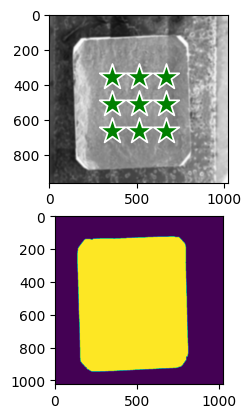

In [5]:
'''SAM interactive'''
idx += 1
d_pos = .3
grid_spacing = 32
RANDOM_POSITIONS=20
input_size = 1024

def SAM_surface_segmentation(path):
    all_points = []
    input_label = []
    image = cv2.imread(path)
    image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
    if(input_size==1024):
        image = image[0:960,:]
    image_blurred = cv2.blur(cv2.blur(image,(6,6)),(10,10))
    condition_img = image_blurred>253
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    #Remove reflective edges
    condition_img = image_blurred>253
    non_zero_indices = np.nonzero(np.where(condition_img,1,0))
    # if len(non_zero_indices[0]) > 0:
    #     for i in range(RANDOM_POSITIONS):
    #         temp_idx = int(random.random()*len(non_zero_indices[0]))
    #         all_points.append([non_zero_indices[1][temp_idx],non_zero_indices[0][temp_idx]])
    #         input_label.append(0)

    for x_pos in [len(image_blurred[0])*.65,len(image_blurred[0])*.5,len(image_blurred[0])*.35]:
        for y_pos in [len(image_blurred[1])*.65,len(image_blurred[0])*.5,len(image_blurred[1])*.35]:
            all_points.append([x_pos,y_pos])
            input_label.append(1)
    image = cv2.resize(image,(input_size,input_size), interpolation = cv2.INTER_AREA)
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=np.array(all_points),
        point_labels=np.array(input_label),
        multimask_output=False,
    )
    processed_mask = (masks[0]).astype(np.uint8) * 255

    # Step 1: Label connected components
    num_labels, labels_im = cv2.connectedComponents(processed_mask)

    # Step 2: Count pixels for each label
    sizes = np.bincount(labels_im.ravel())

    # Step 3: Find the largest component (ignore the background)
    largest_component_label = sizes[1:].argmax() + 1  # +1 to offset background

    # Step 4: Create a new mask for the largest component
    largest_defect_mask = np.zeros_like(processed_mask)
    largest_defect_mask[labels_im == largest_component_label] = 255
    processed_mask = largest_defect_mask
    # Creating kernel 
    dilate_kernel = np.ones((6, 6), np.uint8)
    erosion_kernal = np.ones((6, 6), np.uint8)
    # Using cv2.erode() method  
    processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    # processed_mask = cv2.dilate(processed_mask, dilate_kernel, cv2.BORDER_REFLECT) #
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.erode(processed_mask, erosion_kernal, cv2.BORDER_REFLECT) 
    processed_mask = cv2.dilate(processed_mask, np.ones((30, 30), np.uint8), cv2.BORDER_REFLECT) #

    # fill_mask_holes from Claude 3.5 Sonnet Oct. 23, 2024
    def fill_mask_holes(mask):
        """
        Fill holes in a binary mask using floodFill.
        
        Parameters:
        mask (numpy.ndarray): Binary input mask (0 and 255 values)
        
        Returns:
        numpy.ndarray: Mask with holes filled
        """
        # Ensure mask is binary and of type uint8
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)
        
        # Threshold to ensure binary image
        _, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
        
        # Create a copy of the mask for flood filling
        # Note: floodFill needs a mask that's 2 pixels bigger in each direction
        h, w = binary_mask.shape
        filled_mask = binary_mask.copy()
        filling_mask = np.zeros((h + 2, w + 2), np.uint8)
        
        # Flood fill from point (0,0)
        cv2.floodFill(filled_mask, filling_mask, (0,0), 255)
        
        # Invert the flood-filled image
        filled_mask_inv = cv2.bitwise_not(filled_mask)
        
        # Combine the original mask with the filled holes
        out_mask = binary_mask | filled_mask_inv
        
        return out_mask
    max_mask = fill_mask_holes(processed_mask)
    return image_blurred, max_mask, all_points, input_label

input_image, output_image, all_points, input_label = SAM_surface_segmentation(stitched_imgs['image_path'].iloc[idx])
fig, ax = plt.subplots(2)
ax[0].imshow(input_image)
show_points(np.array(all_points), np.array(input_label), ax[0])
ax[1].imshow(output_image)
plt.show()

In [6]:
'''Applying To All Stitched Images'''
save_path = '/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/SAM_whole_surface'
for i,row in stitched_imgs.iterrows():
    print(i)
    input_image,output_image, _,_ = SAM_surface_segmentation(row['image_path'])
    cv2.imwrite(save_path+'/stitched_surface_unseg_'+row['image_basename'],input_image)
    cv2.imwrite(save_path+'/whole_surface_seg_'+row['image_basename'],output_image)

8
16
22
28
36
46
69
81
114
123
138
147
156
176
186
201
220
231
238
245
253
266
277
283
290
306
315
328
339
347
352
358
364
372
378
384
390
396
408
417
423
430
436
442
451
457
463
469
476
485
491
499
505
511
517
522
528
534
540
546
553
559
566
572
578
584
590
596
603
609
615
622
630
636
643
653
668
673
679
688
696
702
708
714
721
730
736
742
748
754
760
766
816
840
846
852
858
864
870
881
888
899
905
911
917
923
927
933
939
944
950
957
965
975
985
991
998
1004
1012
1019
1025
1031
1037
1043
1049
1055
1061
1067
1088
1096
1100
1107
1115
1125
1135
1141
1149
1156
1175
1181
1187
1193
1226
1232
1238
1247
1257
1266
1272
1279
1285
1291
1297
1303
1310
1316
1323
1329
1335
1341
1351
1357
1364
1370
1376
1382
1391
1398
1404
1410
1416
1422
1428
1434
1440
1461
1471
1494
1502
1510
1518
1533
1543
1551
1579
1586
1599
1608
1617
1633
1640
1648
1662
1669
1676
1685
1702
1713
1723
1732
1752
1758
1769
1780
1785
1790
1804
1811
1818
1829
1838
1845
1863
1879
1888
1895
1901
1908
1915
1922
1928
1936
1946
1953
1960
1

In [33]:
import os
def load_SAM__segmentation():    
    paths_list = []
    basename_lists = []
    for path in os.listdir(save_path):
        if 'seg' in path:
            paths_list.append(save_path+'/'+path)
            basename_lists.append(path.removeprefix("whole_surface_seg_"))
    return pd.concat([pd.Series(paths_list,name='image_path'),pd.Series(basename_lists,name='image_basename')],axis=1)
segmented_df = load_SAM__segmentation()

# print(combined_df['image_basename'].drop_duplicates().value_counts())
for group_string, sample in combined_df.groupby('image_basename'):
    if 'stitched' in sample['image_class'].value_counts().index:
        print(group_string)
        print(sample[sample['image_class']=='stitched']['image_path'].iloc[0]) #Some images have duplicate paths
    # stitched_path = sample[sample['image_class']=='stitched']['image_path']
    # print(stitched_path)
    # for image in segmented_df[segmented_df['image_basename']==group_string]['image_path']:
    #     print(image)

CMU01-1-1 STITCHED.tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-1/CMU01-1-1 STITCHED.tif
CMU01-1-2 STITCHED.tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-1/CMU01-1-2 STITCHED.tif
CMU01-10-1 (stitched).tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-10/CMU01-10-1 (stitched).tif
CMU01-10-2 (stitched).tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-10/CMU01-10-2 (stitched).tif
CMU01-11-2-stitched.tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-11/CMU01-11-2-stitched.tif
CMU01-11-2-stitched_MARKED.tiff
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-11/CMU01-11-2-stitched_MARKED.tiff
CMU01-12-2_stitched.tif
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-12/CMU01-12-2_stitched.tif
CMU01-12-2_stitched_MARKED.tiff
/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/CMU01(KH to PW)/CMU01-1